# 20 NewsGroup NLP Classification

In [133]:
import pandas as pd 
import numpy as np 
from scipy import stats
import matplotlib.pyplot as plt
import os
from os.path import isfile, join
import string
import time
import re
from string import punctuation
import sys

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
import spacy
nlp = spacy.load('en_core_web_sm')
from nltk.tokenize import RegexpTokenizer

from sklearn.datasets import fetch_20newsgroups
from sklearn.preprocessing import LabelEncoder , StandardScaler , MaxAbsScaler 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.feature_extraction.text import CountVectorizer ,TfidfVectorizer
import itertools

import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Input, Dropout
from keras import Sequential
from keras import metrics

from keras.models import load_model
import joblib

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    # print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    cbar = plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #cbar.remove()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def timing(f):
    def wrap(*args, **kwargs):
        time1 = time.time()
        ret = f(*args, **kwargs)
        time2 = time.time()
        print('{:s} function took {:.3f} ms'.format(f.__name__, (time2-time1)*1000.0))

        return ret
    return wrap



def downsample(df):
    minority_frequency  = df['label'].value_counts()[-1]
    minority_label = df['label'].value_counts().index[-1]
    
    df_balanced = df.loc[df['label'] == minority_label , : ].sample(minority_frequency).copy()
    df_balanced = df_balanced.reset_index(drop = True)
    
    label_list = df['label'].value_counts().index.tolist()
    #Sample and concat
    for label in label_list:
        if label != minority_label:
            sample_df = df.loc[df['label'] == label , : ].sample(minority_frequency).copy()
            df_balanced = pd.concat([ df_balanced , sample_df],axis = 0 , ignore_index=True) 
    # Shuffle data
    df_balanced = df_balanced.sample(frac = 1).reset_index(drop = True)
    
    return df_balanced

class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()
    
#Need OPT
def spacy_preprocessing(text_format):
        
    def combine_text(list_of_text):
            combined_text = ' '.join(list_of_text)
            return combined_text
        
    doc  = nlp(text_format)
    tokens_list  = [ token for token in doc if not token.is_punct and not token.is_space and token.is_alpha]
    filter_token_sw = [token.lemma_ for token in tokens_list if str.lower(str.strip(token.lemma_)) not in stopwords.words('english')]
   
    return combine_text(filter_token_sw)

def word_freq(label): return pd.Series([ t for t in nlp(grouped_vocabolary[label])] ).value_counts()

vec_prop = np.vectorize(spacy_preprocessing)
pipe_spacy_preprocessing = FunctionTransformer(vec_prop)
prep_pipeline = Pipeline([
                    ('text_preprocessing', pipe_spacy_preprocessing )
                    ])

def make_custom_predictions(fitted_pipe):
    prep_text = pipe_spacy_preprocessing.transform( pd.Series(input('Input-Text:')))
    predictions_proba = pd.Series( keras_model_emb.model.predict( emb_class.transform(prep_text) )[0] , index= label_names)

    ranked_predictions  = predictions_proba.sort_values(ascending=True)

    ax = plt.subplot(111)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    chart = ax.barh(ranked_predictions.index ,ranked_predictions )
    plt.title('Predictions')
    return chart , ranked_predictions



def save_keras_pipe(pipeline,name_model = 'keras_model.h5', name_pipe ='sklearn_pipeline.pkl' ):
    # Save the Keras model first:
    pipeline.named_steps['kc'].model.save(name_model)

    # This hack allows us to save the sklearn pipeline:
    pipeline.named_steps['kc'].model = None

    # Finally, save the pipeline:
    joblib.dump(pipeline, name_pipe)

from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter

In [2]:
#______________________________________________________ DATA INGESTION___________________________________________________________________
dataset = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), shuffle=True, random_state=42)
df = pd.DataFrame()
df['text'] = dataset.data
df['source'] = dataset.target
label=[]
for i in df['source']:
    label.append(dataset.target_names[i])
df['label']=label
df.drop(['source'],axis=1,inplace=True)

#++++++++++++++++++++++++++++++++++++++++Macro Categories++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
key_categories = ['politics','sport','religion','computer','sales','automobile','science','medicine']
cat_dict = {
**dict.fromkeys(['talk.politics.misc','talk.politics.guns','talk.politics.mideast'],'politics'),
**dict.fromkeys( ['rec.sport.hockey','rec.sport.baseball'],'sport'),
**dict.fromkeys( ['soc.religion.christian','talk.religion.misc'],'religion'),
**dict.fromkeys(['comp.windows.x','comp.sys.ibm.pc.hardware','comp.os.ms-windows.misc','comp.graphics','comp.sys.mac.hardware'],'computer'),
**dict.fromkeys( ['misc.forsale'],'sales'),
**dict.fromkeys( ['rec.autos','rec.motorcycles'],'automobile'),
**dict.fromkeys( ['sci.crypt','sci.electronics','sci.space'],'science'),
**dict.fromkeys( ['sci.med'],'medicine') 
}
df['label']=df['label'].map(cat_dict)
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Encode categorical variables in integer levels 
label_encoder = LabelEncoder()  
# Encode labels in column 
df['target']= label_encoder.fit_transform(df['label'])

#SHuffle
df = df.sample(frac = 1)
# DROPNAN
df = df.dropna()
# dependent and independent variable
X = df['text']
y = df['target']
#_____________________________________________________________________________________________________________________________________________
df['label'].value_counts()

computer      2936
science       1779
politics      1575
sport         1197
automobile    1192
religion       976
medicine       594
sales          585
Name: label, dtype: int64

In [3]:
print(df.shape)
df.head()

(10834, 3)


,text,label,target
8009,"Hi everyone,\n\nI'm getting a car in the near ...",automobile,0
10127,You might want to clarify the 11 game winning ...,sport,7
7184,\nThe letter implies that both warrants were i...,politics,3
4547,} >>\n} >>>Has Jack lost a bit of his edge? Wh...,sport,7
8466,\nNo. There are two problems here:\n\n(1) Pet...,religion,4


# Data Exploration

In [4]:
# Downsample dataset to make it balanced without changing the data and make eda faster
df_balanced = downsample(df)

# Create Tokens and text as columns
df_s = df_balanced.copy()

#+++++++++++++++++++++++ Create Token and clean them ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
df_s['tokens'] = df_s['text'].apply( lambda x : [token for token in nlp(x) if ( not token.is_punct and \
                                                                                not token.is_space  and \
                                                                                token.is_alpha and \
                                                                                str.lower(str.strip(token.lemma_)) not in stopwords.words('english')  ) ] )
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

df_s['label'].value_counts()

sport         585
sales         585
automobile    585
politics      585
computer      585
medicine      585
religion      585
science       585
Name: label, dtype: int64

In [5]:
df_s['lemma_'] = df_s['tokens'].apply(lambda x: [ str.strip(token.lemma_) for token in  x  ] )

# Length of the list of lemma in text
df_s['len_lemma_text'] = df_s['lemma_'].apply(lambda x: len(x) )
# Unique words in lemma
df_s['lemma_unique'] = df_s['lemma_'].apply(lambda x: list(set(x)) ) 
# Lenght of Unique words in lemma
df_s['len_lemma_unique_text'] = df_s['lemma_unique'].apply(lambda x:len( set(x) ) )
# Proportion of unique lemma on the lenght of NON unique lemma , the lower the value the more the words in text are repeated
df_s['richness_text'] = df_s['len_lemma_unique_text']/df_s['len_lemma_text'] 

# Drop NAN if text was empty after tokenization
df_s = df_s.loc[ df_s['len_lemma_text'] != 0  , : ]

# Balance again 
df_s = downsample(df_s)

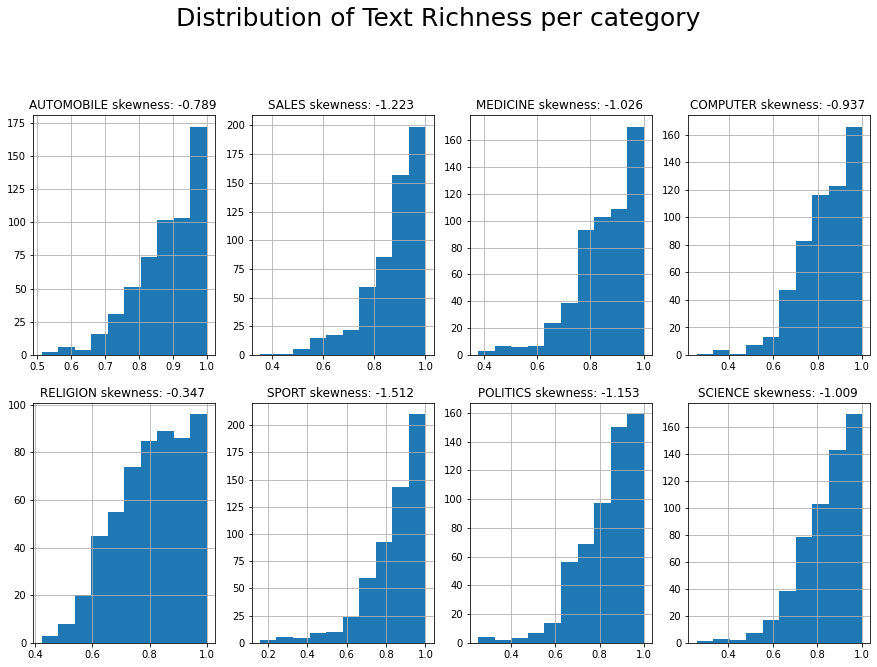

In [6]:
fig = plt.figure(figsize=(15,15))
fig.suptitle('Distribution of Text Richness per category',fontsize=25)
for n,i in enumerate( df_s['label'].unique() ):
    ax = fig.add_subplot(3,4,n+1)
    abs_freq = df_s.loc[ df_s['label'] == i,'richness_text'] 
    (abs_freq).hist(ax  = ax )
    values = df_s.loc[ df_s['label'] == i,'richness_text']
    ax.set_title(str.upper(i) + f' skewness: {round(stats.skew(values),3)  } ' )
#     ax.axis('off')

In [7]:
from itertools import chain
group_class_docs = df_s.groupby('label')['lemma_unique'].apply(list) 
group_class_uniqe_texts = group_class_docs.apply(lambda x : list(itertools.chain(*x)))

Text(0.5, 1.0, 'Lenght of Vocabolary for each category')

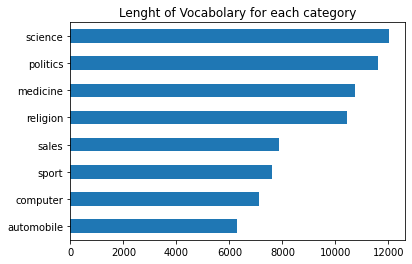

In [62]:
vocabolary_len_per_category = pd.Series({cat :len(group_class_uniqe_texts.apply(lambda x:list(set(x)))[cat]) for cat in df_s.label.unique() })
vocabolary_len_per_category.sort_values().plot(kind = 'barh').set_title('Lenght of Vocabolary for each category')

In [9]:
min(vocabolary_len_per_category)

6291

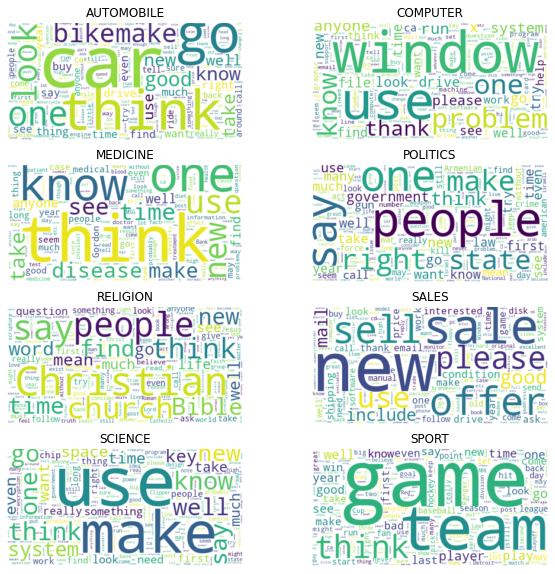

In [10]:
grouped_vocabolary = group_class_uniqe_texts.apply(lambda x:str(' '.join(x)))
vocabulary_len_category = dict({ k:len(word_freq(k).index.to_list()) for k in grouped_vocabolary.index.to_list() } )

fig = plt.figure(figsize=(10,10))
for n,i in enumerate(grouped_vocabolary.index.to_list()):
    ax = fig.add_subplot(4,2,n+1)
    wordcloud = WordCloud(max_words=3000,background_color="white").generate(str(grouped_vocabolary[i]))
    ax.set_title(str.upper(i) ) 
    ax.axis('off')
    ax.imshow(wordcloud,interpolation="bilinear")
plt.show()

In [11]:
[ token for token in nlp(df_s.loc[0,'text']) if ( not token.is_punct and \
                                          not token.is_space  and \
                                          token.is_alpha and \
                                          str.lower(str.strip(token.lemma_)) not in stopwords.words('english')  ) ] 

[new,
 BMW,
 owner,
 thinking,
 signing,
 MOA,
 right,
 beginning,
 look,
 suspiciously,
 like,
 throwing,
 money,
 rathole,
 guys,
 sort,
 let,
 know]

# Preprocessing Pipeline 

In [12]:
vec_prop = np.vectorize(spacy_preprocessing)
pipe_spacy_preprocessing = FunctionTransformer(vec_prop)

prep_pipeline = Pipeline([
                    ('text_preprocessing', pipe_spacy_preprocessing )
                    ])

# DEFINE LABELS IN OHE FORMAT
yc = tf.keras.utils.to_categorical(y,num_classes = 8,dtype=int )

In [13]:
#++++++++++++++++++++++++++++ Preprocessing informative texts balances ++++++++++++++++++++++++++++++++++++
X = df_s['text']
y = df_s['target']

# Transform text
X_t = prep_pipeline.fit_transform(X)
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Model Pipeline- Approach TF-IDF

In [20]:
#++++++++++++++++++++++++++++++++++++++++++ Pipeline Defition and Params +++++++++++++++++++++++++++++++++

# TF IDF DIMENSION will affect the model 
matrix_features  = 3000 # Optmized to best performance starting from 6000 , min lenght of vocabolary

n_classes =y.nunique()


def create_model(features = matrix_features ,optimizer="adam",
                 dense_layer_sizes = False,
                 dropout=0.1, init='uniform',
                 neurons=20,
                 n_classes = 8 ):
    
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_shape=(features,),kernel_initializer=init)) #
    model.add(Dropout(dropout), )    

    #for layer_size in dense_layer_sizes:
    #   model.add(Dense(layer_size, activation='relu'))
    #   model.add(Dropout(dropout), )    
    
    model.add(Dense(n_classes, activation='softmax')) # because we want the probability of each class as output , len 8 
    model.compile(loss='sparse_categorical_crossentropy', # sparse because it can accept the integer cat as y . len1 
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

#dense_layer_sizes = [[] , []]
#param_grid = dict(neurons=neurons, epochs = epochs, batch_size =batch_size)
param_grid = {
    'tfidf__ngram_range': [(1,1)],
    'kc__epochs': [20,30,50],
    'kc__neurons': [10, 20, 30, 100],
    'kc__batch_size':[16, 32,50],
    'kc__dropout': [ 0.3, 0.1, 0]
}


model_pipeline = Pipeline([
                    ('tfidf', TfidfVectorizer(use_idf = True,max_features=matrix_features)),
                    ('sparse_to_dense',DenseTransformer()),
                    ('scaler', MaxAbsScaler()),
                    ('kc' ,KerasClassifier(build_fn=create_model, verbose = 0))
])

folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
grid = GridSearchCV(estimator=model_pipeline,
                    verbose=1,
                    cv=skf.split(X_t,y),
                    param_grid=param_grid,
                    scoring='accuracy')


#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
from sklearn import set_config
set_config(display='diagram')
grid

C:\Users\david\AppData\Local\Temp/ipykernel_21444/617889417.py:44: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  ('kc' ,KerasClassifier(build_fn=create_model, verbose = 0))


GridSearchCV(cv=<generator object _BaseKFold.split at 0x0000023E5632A5F0>,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=6000)),
                                       ('sparse_to_dense',
                                        <__main__.DenseTransformer object at 0x0000023E19337790>),
                                       ('scaler', MaxAbsScaler()),
                                       ('kc',
                                        <keras.wrappers.scikit_learn.KerasClassifier object at 0x0000023E19337310>)]),
             param_grid={'kc__batch_size': [16, 32, 50],
                         'kc__dropout': [0.3, 0.1, 0],
                         'kc__epochs': [20, 30, 50],
                         'kc__neurons': [10, 20, 30, 100],
                         'tfidf__ngram_range': [(1, 1)]},
             scoring='accuracy', verbose=1)

## Hyperparameters-tuning  and CrossValidation

In [21]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


#++++++++++++++++++++++++++++++ RUN GRID ++++++++++++++++++++++++++++++++++++
t0 = time.time()
grid_fitted = grid.fit(X_t,y) # Pipe line fitted with preprocessed clean text spacy
results  =  pd.DataFrame(grid_fitted.cv_results_).sort_values('rank_test_score')

t1 = time.time()
delta = t1-t0
print(f'Tuning Time s: {round(delta,3)}')
display( results.head() ) 

In [43]:
#+++++++++++++++++++++++ BEST PIPE PARAMS ++++++++++++++++++++++++++++++++
opt_pipeline  = grid_fitted.best_estimator_

t0 = time.time()
fitted_pipe = opt_pipeline.fit(X_t,y)
time.time() - t0 

5.293804883956909

In [ ]:
#save_keras_pipe(fitted_pipe,name_model = f'keras_model_{matrix_features}.h5', name_pipe =f'sklearn_pipeline_{matrix_features}.pkl' )
# Possible Error Dense Transformer Class pickle

# Model Pipeline- Approach Word Embedding

In [26]:
import tensorflow_hub as hub
# load embeddings model from Tensorflow Hub
#https://stackoverflow.com/questions/62464152/universal-sentence-encoder-load-error-error-savedmodel-file-does-not-exist-at
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


matrix_features  = 512
def create_model(optimizer="adam",
                 dense_layer_sizes = False,
                 dropout=0.1, init='uniform',
                 features=matrix_features,neurons=20,
                 n_classes = n_classes ):
    
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_shape=(features,),kernel_initializer=init)) #
    model.add(Dropout(dropout), )    

    #for layer_size in dense_layer_sizes:
    #   model.add(Dense(layer_size, activation='relu'))
    #   model.add(Dropout(dropout), )    
    
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

n_classes =y.nunique()


In [28]:
class Embedding(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return embed(X).numpy()
    
emb_pipeline = Pipeline([
                    ('embed', Embedding()),
                    ('kc' ,KerasClassifier(build_fn=create_model, verbose = 0))
])

#++++++++++++++++++++++++++++++ GRID ++++++++++++++++++++++++++++++++++++++
param_grid = {
    'kc__epochs': [20,30,50],
    'kc__neurons': [10, 20, 30, 100],
    'kc__batch_size':[16, 32,50],
    'kc__dropout': [ 0.3, 0.1, 0]
}

folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
grid = GridSearchCV(estimator=emb_pipeline,
                    verbose=1,
                    cv=skf.split(X_t,y),
                    param_grid=param_grid,
                    scoring='accuracy')

C:\Users\david\AppData\Local\Temp/ipykernel_21444/2466700516.py:11: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  ('kc' ,KerasClassifier(build_fn=create_model, verbose = 0))


In [60]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


#++++++++++++++++++++++++++++++++++++ GRID Search +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
t0 = time.time()
grid_fitted = grid.fit(X_t,y) # Pipe line fitted with preprocessed clean text spacy
results  =  pd.DataFrame(grid_fitted.cv_results_).sort_values('rank_test_score')

t1 = time.time()
delta = t1-t0
print(f'Tuning Time s: {round(delta,3)}')
display( results.head() )

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Tuning Time s: 7713.265


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kc__batch_size,param_kc__dropout,param_kc__epochs,param_kc__neurons,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
85,16.026138,2.011214,6.481584,0.832069,50,0.1,20,20,"{'kc__batch_size': 50, 'kc__dropout': 0.1, 'kc...",0.803476,0.824866,0.825535,0.817959,0.010245,1
86,15.963058,2.206833,5.991242,0.669894,50,0.1,20,30,"{'kc__batch_size': 50, 'kc__dropout': 0.1, 'kc...",0.802139,0.824198,0.826203,0.817513,0.010902,2
74,16.024231,1.526593,7.040378,0.951794,50,0.3,20,30,"{'kc__batch_size': 50, 'kc__dropout': 0.3, 'kc...",0.804813,0.823529,0.822861,0.817068,0.008670,3
38,16.183935,0.757908,6.607857,0.815253,32,0.3,20,30,"{'kc__batch_size': 32, 'kc__dropout': 0.3, 'kc...",0.801471,0.822193,0.826872,0.816845,0.011038,4
2,15.089599,0.872563,5.553469,0.492411,16,0.3,20,30,"{'kc__batch_size': 16, 'kc__dropout': 0.3, 'kc...",0.803476,0.822193,0.823529,0.816399,0.009154,5


In [29]:
#++++++++++++++++++++++++++++++++++++++++++++++ Fit the best model for embedding based on Grid +++++++++++++++++++++++++
emb_class = Embedding().fit(X_t)
keras_model_emb = create_model(features=512, neurons=30, n_classes=8, dropout=0.3).fit(emb_class.transform(X_t),
                                                                                       y,
                                                                                       batch_size = 30,
                                                                                       epochs = 50 ,
                                                                                       verbose= 0  )

# Testing 

In [30]:
dataset = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), shuffle=True, random_state=42)
df = pd.DataFrame()
df['text'] = dataset.data
df['source'] = dataset.target
label=[]
for i in df['source']:
    label.append(dataset.target_names[i])
df['label']=label
df.drop(['source'],axis=1,inplace=True)

#++++++++++++++++++++++++++++++++++++++++Macro Categories++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
key_categories = ['politics','sport','religion','computer','sales','automobile','science','medicine']
cat_dict = {
**dict.fromkeys(['talk.politics.misc','talk.politics.guns','talk.politics.mideast'],'politics'),
**dict.fromkeys( ['rec.sport.hockey','rec.sport.baseball'],'sport'),
**dict.fromkeys( ['soc.religion.christian','talk.religion.misc'],'religion'),
**dict.fromkeys(['comp.windows.x','comp.sys.ibm.pc.hardware','comp.os.ms-windows.misc','comp.graphics','comp.sys.mac.hardware'],'computer'),
**dict.fromkeys( ['misc.forsale'],'sales'),
**dict.fromkeys( ['rec.autos','rec.motorcycles'],'automobile'),
**dict.fromkeys( ['sci.crypt','sci.electronics','sci.space'],'science'),
**dict.fromkeys( ['sci.med'],'medicine') 
}
df['label']=df['label'].map(cat_dict)
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


label_encoder = LabelEncoder()  
# Encode labels in column 'species'.
df['target']= label_encoder.fit_transform(df['label'])

# drop non in categories
df = df.loc[df['label'].isin(key_categories)]
#++++++++++++++++++++++++ PICK RANDOM 30 % OF TEST++++++++++++++++++++++++++
df = df.sample(frac = 1) 
# dependent and independent variable
X_test = df['text']
y_test = df['target']
#_____________________________________________________________________________________________________________________________________________

### Load Models and Predict

In [31]:
X_test_prep = prep_pipeline.transform(X_test)

              precision    recall  f1-score   support

    politics       0.57      0.78      0.65       794
       sales       0.88      0.74      0.80      1955
    religion       0.65      0.73      0.69       396
     science       0.74      0.70      0.72      1050
    medicine       0.71      0.77      0.74       649
    computer       0.57      0.83      0.68       390
       sport       0.69      0.61      0.65      1183
  automobile       0.90      0.83      0.86       796

    accuracy                           0.73      7213
   macro avg       0.71      0.75      0.72      7213
weighted avg       0.75      0.73      0.74      7213

Confusion matrix, without normalization


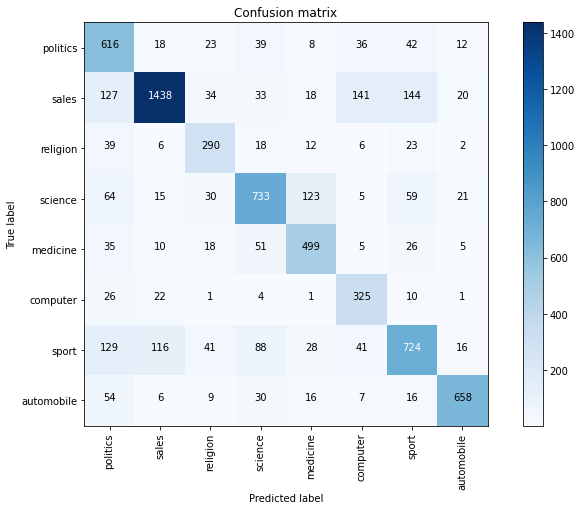

In [58]:
#Load the pipeline first:
chosen_pipe = 'sklearn_pipeline.pkl'
pipeline = joblib.load(chosen_pipe)
# Then, load the Keras model:

chosen_model = 'keras_model.h5'
pipeline.named_steps['kc'].model = load_model(chosen_model) 


# pipeline = fitted_pipe
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#X_test_prep = prep_pipeline.transform(X_test)
y_pred  = pipeline.predict(X_test_prep)
cnf_matrix = confusion_matrix(y_test,y_pred)

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(10, 7, forward=True)
#fig.align_labels()

label_names = df['label'].unique()

print(classification_report(y_test,y_pred, target_names=label_names))
# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(label_names), normalize=False,
                      title='Confusion matrix')

              precision    recall  f1-score   support

    politics       0.78      0.76      0.77       794
       sales       0.80      0.79      0.79      1955
    religion       0.68      0.83      0.75       396
     science       0.78      0.76      0.77      1050
    medicine       0.77      0.80      0.79       649
    computer       0.53      0.78      0.63       390
       sport       0.72      0.62      0.67      1183
  automobile       0.92      0.87      0.90       796

    accuracy                           0.77      7213
   macro avg       0.75      0.78      0.76      7213
weighted avg       0.77      0.77      0.77      7213

Confusion matrix, without normalization


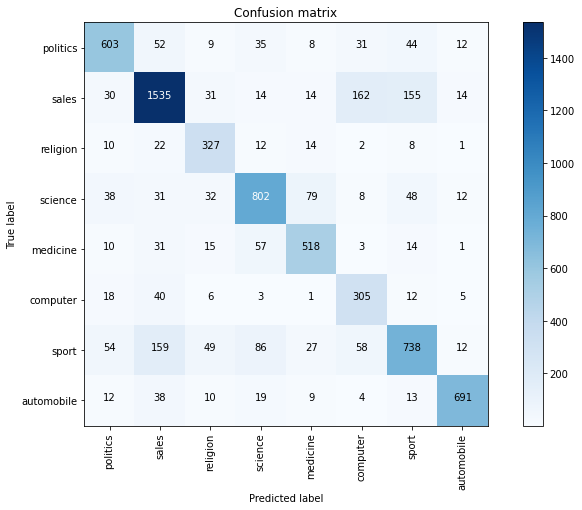

In [59]:
y_pred = np.argmax( keras_model_emb.model.predict( emb_class.transform(X_test_prep) )  , axis=-1 ) 

cnf_matrix = confusion_matrix(y_test,y_pred)

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(10, 7, forward=True)
#fig.align_labels()
label_names = df['label'].unique()
print(classification_report(y_test,y_pred, target_names=label_names))
# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(label_names), normalize=False,
                      title='Confusion matrix')

Input-Text: Hardware refers to the physical components of a computer. Computer Hardware is any part of the computer that we can touch these parts. These are the primary electronic devices used to build up the computer. Examples of hardware in a computer are the Processor, Memory Devices, Monitor, Printer, Keyboard, Mouse, and the Central Processing Unit.


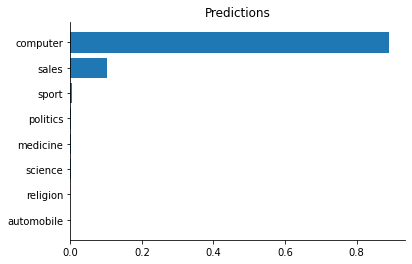

In [134]:
chart , ranked_predictions = make_custom_predictions(fitted_pipe)